## Qiskit Circuit to Tensorflow Quantum
***
The aim of the toolkit is to help users understand QAOA circuits better and also to not limit their use to a single library. As such we have added support for Google's Tensorflow Quantum ML library which can help users to run the circuit using IBM's simulator with the aid of Google's Tensorflow. We also aim to provide more support for various other ML libraries in the furture if possible.



### 1. QML on Tensorflow Quantum
***
Tensorflow quantum uses Google's Cirq library to run the quantum machine learning for QAOA circuits. Before going through the convertion process, we will go through regular process for quantum tensorflow.

First import the relvant libraries:

In [1]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import sympy

Then generate the graph for the problem, in this case we will going throught the usual MAX-CUT problem. For the graph all the weights are set 1.

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{(0, 1): Text(0.654508480212244, 0.4755283023511464, '1.0'),
 (0, 2): Text(0.09549145273252935, 0.2938926212887637, '1.0'),
 (1, 2): Text(-0.2500000670552266, 0.7694208997980517, '1.0'),
 (2, 3): Text(-0.8090170349302954, -6.55651103964594e-08, '1.0'),
 (2, 4): Text(-0.24999999254941926, -0.18163562741820138, '1.0'),
 (3, 4): Text(-0.24999993294477343, -0.7694209117189807, '1.0')}

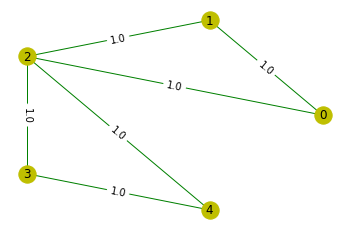

In [2]:
# Create a graph for the problem its is also adviseable to instantiate the weight of the graphs else it 
# be defaulted to 1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0))
labels = nx.get_edge_attributes(G,'weight')

nx.draw(G,with_labels=True, pos=nx.circular_layout(G), node_color='y', edge_color='g')
nx.draw_networkx_edge_labels(G,nx.circular_layout(G),edge_labels=labels)

Just like in qiskit, in Cirq we need to declare the number of qubits, in Cirq we are given the option of choosing the qubit arrangement, for this case we will choose grid arragement for the qubits:

In [3]:
cirq_qubits = cirq.GridQubit.rect (1 , G.number_of_nodes())

Initialize the initial hadamrd gates to put the qubits in equal superposition and this portion of the circuit will also serve as the input tensor for tensorflow to perform the optimization

In [4]:
hadamard_circuit = cirq.Circuit ()

for node in G.nodes ():
    qubit = cirq_qubits [ node ]
    hadamard_circuit.append(cirq.H.on(qubit))
    
hadamard_circuit

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

Just like in the toolkit, we have to generate the Cost and Mixer hamitlonians serperately. Cirq uses sympy to map the symbols to the circuit parameters. The Cost and Mixer Hamiltonians in this case is expressed as cirq's PauliSum expression which can be converted to a circuit later. This is done so that the cost hamitlonian can used to calculate the expectation value when running the optimization process.

In [5]:
# Cirq uses sympy to denote the hyperparameters, Gamma(g) and Beta(b)
qaoa_parameters = sympy.symbols('g,b')

# Generte the mixer hamiltonian using Cirq Gates
mixing_ham = 0
for node in G.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))
    
print(mixing_ham)

1.000*X((0, 0))+1.000*X((0, 1))+1.000*X((0, 2))+1.000*X((0, 3))+1.000*X((0, 4))


In [6]:
cost_ham = G.number_of_edges()/2

for edge in G.edges () :
    qubit1 = cirq_qubits [edge[0]]
    qubit2 = cirq_qubits [edge[1]]
    cost_ham += cirq.PauliString(1/2*( cirq.Z(qubit1)*cirq.Z( qubit2 )))
    
print(cost_ham)

0.500*Z((0, 0))*Z((0, 1))+3.000*I+0.500*Z((0, 0))*Z((0, 2))+0.500*Z((0, 1))*Z((0, 2))+0.500*Z((0, 2))*Z((0, 3))+0.500*Z((0, 2))*Z((0, 4))+0.500*Z((0, 3))*Z((0, 4))


Finally, we can convert the PauliSums into a quantum circuit using tfq's exponential() function which converts the PauliSum objects to circuits and maps the parameters to the relavant parametric gates via exponentiation.

In [7]:
qaoa_circuit = tfq.util.exponential (operators=[cost_ham, mixing_ham], coefficients=qaoa_parameters)
qaoa_circuit

(0, 0): ───@───────────────@───X───Z^(-0.954929658551372*g)───X───Z^(-0.954929658551372*g)───@───────────────@───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────────────────────────────────────────────
           │               │                                                                 │               │
(0, 1): ───X───Rz(1.0*g)───X─────────────────────────────────────────────────────────────────┼───────────────┼───@───────────────@───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────────────────────────
                                                                                             │               │   │               │
(0, 2): ─────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───X───Rz(1.0*g)───X───@───────────────@───@───────────────@───────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────────────────────────
                                                                                                                                     │               │   │               │
(0, 3): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───┼───────────────┼───@───────────────@───────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───────────────────────
                                                                                                                                                         │               │   │               │
(0, 4): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(1.0*g)───X───X───Rz(1.0*g)───X───────────────────────────────────────────────────────────────────────────────────H───Rz(2.0*b)───H───

In [8]:
# define the model and training data
model_circuit , model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)

Now we have to build the keras model using tensorflow. However, the quantum circuit can be converted into the quantum tensor by using PQC function(Paramteric Quantum Circuit) function to convert the circuit into tensors and layers for the optimization process.

In [9]:
optimum = [0]

# Build the Keras model .
optimum = np.array(optimum)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string ))
model.add(tfq.layers.PQC(model_circuit, model_readout ))

Now we run the process and find out the optimal hyperparamters using the Adam optimizer:

In [10]:
model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam())

history = model.fit(input_, optimum, epochs=1000 ,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 1s 1s/sample - loss: 3.5239
Epoch 2/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5181
Epoch 3/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5122
Epoch 4/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.5064
Epoch 5/1000
1/1 [==============================] - 0s 4ms/sample - loss: 3.5006
Epoch 6/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.4948
Epoch 7/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.4890
Epoch 8/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.4832
Epoch 9/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.4775
Epoch 10/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.4717
Epoch 11/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.4659
Epoch 12/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.4602
Epoch 1

Epoch 101/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.0306
Epoch 102/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.0269
Epoch 103/1000
1/1 [==============================] - 0s 6ms/sample - loss: 3.0232
Epoch 104/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.0195
Epoch 105/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.0158
Epoch 106/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.0122
Epoch 107/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.0085
Epoch 108/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.0050
Epoch 109/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.0014
Epoch 110/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.9978
Epoch 111/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.9943
Epoch 112/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.9908
Epoc

Epoch 200/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7516
Epoch 201/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7493
Epoch 202/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7471
Epoch 203/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7449
Epoch 204/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7427
Epoch 205/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7405
Epoch 206/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7383
Epoch 207/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7360
Epoch 208/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7338
Epoch 209/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7316
Epoch 210/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7295
Epoch 211/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.7273
Epoc

Epoch 299/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5341
Epoch 300/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5319
Epoch 301/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5296
Epoch 302/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5274
Epoch 303/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5251
Epoch 304/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.5229
Epoch 305/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.5206
Epoch 306/1000
1/1 [==============================] - 0s 5ms/sample - loss: 2.5184
Epoch 307/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.5161
Epoch 308/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.5139
Epoch 309/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5116
Epoch 310/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.5094
Epoc

Epoch 398/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3210
Epoch 399/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3191
Epoch 400/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3172
Epoch 401/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3153
Epoch 402/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3134
Epoch 403/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.3115
Epoch 404/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3096
Epoch 405/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3077
Epoch 406/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3059
Epoch 407/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.3040
Epoch 408/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3022
Epoch 409/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.3003
Epoc

Epoch 497/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1726
Epoch 498/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1715
Epoch 499/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1705
Epoch 500/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1695
Epoch 501/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1684
Epoch 502/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1674
Epoch 503/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1664
Epoch 504/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1654
Epoch 505/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1644
Epoch 506/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1634
Epoch 507/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1624
Epoch 508/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1614
Epoc

Epoch 596/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1033
Epoch 597/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1029
Epoch 598/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.1025
Epoch 599/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.1021
Epoch 600/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1017
Epoch 601/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1013
Epoch 602/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1009
Epoch 603/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.1006
Epoch 604/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.1002
Epoch 605/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0998
Epoch 606/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0994
Epoch 607/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0991
Epoc

Epoch 695/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0796
Epoch 696/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0794
Epoch 697/1000
1/1 [==============================] - 0s 5ms/sample - loss: 2.0793
Epoch 698/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0792
Epoch 699/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0791
Epoch 700/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0790
Epoch 701/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0789
Epoch 702/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0788
Epoch 703/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0787
Epoch 704/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0785
Epoch 705/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0784
Epoch 706/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0783
Epoc

Epoch 794/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0731
Epoch 795/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0730
Epoch 796/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0730
Epoch 797/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0730
Epoch 798/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0729
Epoch 799/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0729
Epoch 800/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0729
Epoch 801/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0729
Epoch 802/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.0728
Epoch 803/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0728
Epoch 804/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0728
Epoch 805/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0728
Epoc

Epoch 893/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0716
Epoch 894/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0716
Epoch 895/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0716
Epoch 896/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0715
Epoch 897/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0715
Epoch 898/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0715
Epoch 899/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.0715
Epoch 900/1000
1/1 [==============================] - 0s 4ms/sample - loss: 2.0715
Epoch 901/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0715
Epoch 902/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0715
Epoch 903/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0715
Epoch 904/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0715
Epoc

Epoch 992/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 993/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 994/1000
1/1 [==============================] - 0s 3ms/sample - loss: 2.0713
Epoch 995/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 996/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 997/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 998/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 999/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713
Epoch 1000/1000
1/1 [==============================] - 0s 2ms/sample - loss: 2.0713


Now we can extract the parameters and run the circuit using Tensorflow quantum's *sample_layer*, which is slighty different from cirq's simulator. This would return the a list of bitstrings and the number of occurance of the bitstring is the probability:

In [11]:
# Read out the optimal paramters and sample from the final state 1000 times
params = model.trainable_variables
print(params)
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append=qaoa_circuit )

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit, symbol_names=qaoa_parameters, symbol_values=params, repetitions=1000)

[<tf.Variable 'parameters:0' shape=(2,) dtype=float32, numpy=array([1.8928449, 5.698892 ], dtype=float32)>]
Instructions for updating:
reduction_indices is deprecated, use axis instead


Finally, with some post-processing we can find the max cuts for the graph above and the approximation ratio $\alpha$:

In [12]:
# Translate output in cut sets
cuts_qaoa = []
for bit_string in output.values:
    temp = []
    for pos, bit in enumerate(bit_string):
        if bit==1:
            temp.append(pos)
            cuts_qaoa.append(temp)

# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(G.nodes())+1):
    temp = [list(x) for x in combinations(G.nodes(), i)]
    sub_lists.extend(temp)
    
    
cut_size = []
for sub_list in sub_lists:
    cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
    cut_size_qaoa.append(nx.algorithms.cuts.cut_size(G,cut))

# Calculate the approximation ratio
print(np.mean(cut_size_qaoa), np.max(cut_size))
np.mean(cut_size_qaoa)/np.max(cut_size)

1.6942519364044029 4


0.4235629841011007

### Converting QAOAToolkit for Tensorflow:
****
Now to understand the convertion process and issue that inherent in it, we shall first start by using the QAOAToolkit:

In [13]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mix_ham
from expectation_value import expectation_value as ex_vle
from utils.tfq_helper import tfq_helper as helper

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

In [14]:
# Classical objective function for the max-cut problem
obj_function = 'x_u + x_v - 2*x_u*x_v'
variables = ['x_v','x_u']

In [15]:
phase_h = phs_ham(obj_function,variables)
phase_h.get_objFun()

-2*x_u*x_v + x_u + x_v

In [16]:
phase_h.Hamify()
phase_h.get_pHamil()

0.5*I - 0.5*Z_u*Z_v

Following the Toolkit's procedure we can generate the circuits, but in this case since qiskit conversion to QASM2.0 causes error when we replace the hyperparameters with **Sympy Symbols**, therefore, we will have to set the parameters to 1.0, also the new added feature of the expanded Pauli Sum is also provided to further improve the support for tfq tensors: 

**Note this support is limited to p-steps = 1**

In [17]:
# Declare the hyperparameters
gammas = [1]
betas  = [1]

# Instance of the mixer hamiltonian
mx_ham = mix_ham()

# Map both the Mixer and Cost Hamiltonian
phase_h.perEdgeMap(gammas, 1, G, False, False)
phase_hMap = phase_h.qubit_map

mx_ham.generalXMixer(betas,1, phase_hMap, False)
phase_h.get_pHamil()

3.0*I - 0.5*Z_0*Z_1 - 0.5*Z_0*Z_2 - 0.5*Z_1*Z_2 - 0.5*Z_2*Z_3 - 0.5*Z_2*Z_4 - 0.5*Z_3*Z_4

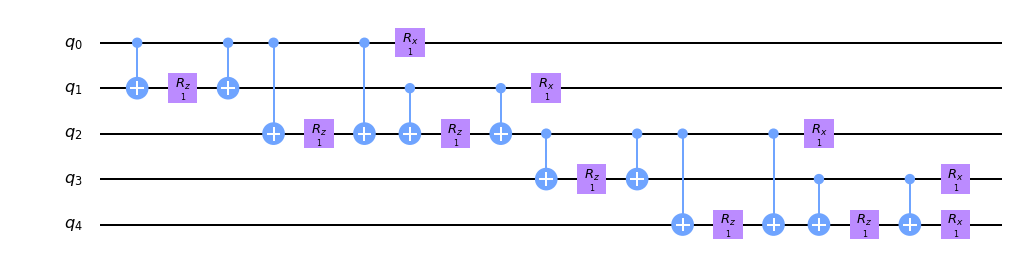

In [18]:
full = phase_h / mx_ham
full.draw(output='mpl')

Tensorflow Quantum requires the input tensor to be an array of Hadamard gates,since the this implementation of hadamard gates is trivial one can set it up using Google's Cirq directly:

In [19]:
# From the Tfq/Cirq example above 
hadamard_circuit

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

However, if you already have the circuit set-up in IBM's Qiskit, you can use the *tfq_helper* functions: *to_tfq_circuit()* to convert the qiskit.QuantumCircuit to Cirq.Circuit via **QASM2.0** which returns a **tuple(Cirq.Circuit,None)**,the 2nd object in the tuple will be discussed later:

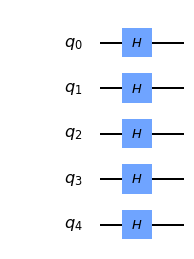

In [20]:
# Set up hadamard ciruit using Qiskit
cir_h = QuantumCircuit(G.number_of_nodes())
for nodes in G.nodes():
    cir_h.h(nodes)
cir_h.draw(output='mpl')

In [21]:
cirq_cir_hadamard = helper.to_tfq_circuit(cir_h)[0]
cirq_cir_hadamard

(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

(0, 3): ───H───

(0, 4): ───H───

The Phase Hamiltonian and Mixer Hamiltonian objects can also be converted using the *to_tfq_circuit()* function, this function is vital as by simply convetrting using QASM method will result in an error.
The issue lies in the fact that the names of qubits converted from **QASM2.0** is treated as **named qubits**, but tensorflow quantum requires the qubit type to be **GridQubit** arrangement so that it can be converted into a tensor. Furthermore, with the symboli hypereparameters, tfq will not be able to tune the values to find the optimal solution.

For the phase Hamiltonian, tfq requires a Cirq.PauliString expression to calculate the expectation value of the circuit. When a phase_hamiltonian object is passed through the function, the p_hamil expression is also converted into a Cirq.PauliString as the 2nd object in the tuple:

In [22]:
cirq_phase = helper.to_tfq_circuit(phase_h)
cirq_phase[0]

(0, 0): ───@────────────────@───@────────────────@───────────────────────────────────────────────────────────────────────────────────────
           │                │   │                │
(0, 1): ───X───Rz(0.318π)───X───┼────────────────┼───@────────────────@──────────────────────────────────────────────────────────────────
                                │                │   │                │
(0, 2): ────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───@────────────────@───@────────────────@────────────────────────
                                                                          │                │   │                │
(0, 3): ──────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───┼────────────────┼───@────────────────@───
                                                                                               │                │   │                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───

In [23]:
print(cirq_phase[1])

1.000*I+0.500*Z((0, 0))*Z((0, 1))+0.500*Z((0, 0))*Z((0, 2))+0.500*Z((0, 1))*Z((0, 2))+0.500*Z((0, 2))*Z((0, 3))+0.500*Z((0, 2))*Z((0, 4))+0.500*Z((0, 3))*Z((0, 4))


Likewise for the Mixer Hamiltonian class but will also return **none** for the 2nd object in the tuple:

In [24]:
cirq_mixer = helper.to_tfq_circuit(mx_ham)[0]
cirq_mixer

(0, 0): ───Rx(0.318π)───

(0, 1): ───Rx(0.318π)───

(0, 2): ───Rx(0.318π)───

(0, 3): ───Rx(0.318π)───

(0, 4): ───Rx(0.318π)───

Since, the both the circuits have been converted into Cirq.Circuit form, one can observe that the hyperparameters are still missing in the circuits,fret not, the tfq_helper class has function called *exponentiate_parameters()* which maps a list of parameters into the cirq.Circuit. You only need a list of hyperparameters as **string** and the full quantum circuit of the problem; you have to combine both the circuits from the phase hamiltonian and the mixer hamiltonian:

In [25]:
#Combine both the circuits
full_circuit = cirq_phase[0] + cirq_mixer
full_circuit

(0, 0): ───@────────────────@───@────────────────@───────────────────────────────────────────────────────────────────────────────────────Rx(0.318π)───
           │                │   │                │
(0, 1): ───X───Rz(0.318π)───X───┼────────────────┼───@────────────────@──────────────────────────────────────────────────────────────────Rx(0.318π)───
                                │                │   │                │
(0, 2): ────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───@────────────────@───@────────────────@────────────────────────Rx(0.318π)───
                                                                          │                │   │                │
(0, 3): ──────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───┼────────────────┼───@────────────────@───Rx(0.318π)───
                                                                                               │                │   │                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318π)───X───X───Rz(0.318π)───X───Rx(0.318π)───

In [26]:
# Declare a list of hyperparameters, gamma (g), beta(b)
hyperparams = ['g','b']

full_circuit_param = helper.exponentiate_parameters(hyperparams, full_circuit)
full_circuit_param

(0, 0): ───@────────────────────────────────@───@────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(0.318309886183791*pi*b)───
           │                                │   │                                │
(0, 1): ───X───Rz(0.318309886183791*pi*g)───X───┼────────────────────────────────┼───@────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(0.318309886183791*pi*b)───
                                                │                                │   │                                │
(0, 2): ────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───X───Rz(0.318309886183791*pi*g)───X───@────────────────────────────────@───@────────────────────────────────@────────────────────────────────────────Rx(0.318309886183791*pi*b)───
                                                                                                                          │                                │   │                                │
(0, 3): ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───┼────────────────────────────────┼───@────────────────────────────────@───Rx(0.318309886183791*pi*b)───
                                                                                                                                                               │                                │   │                                │
(0, 4): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(0.318309886183791*pi*g)───X───X───Rz(0.318309886183791*pi*g)───X───Rx(0.318309886183791*pi*b)───

Viola! Now we can follow the typical procedure of using TFQ to find the optimial hyperparameters:

In [27]:
#Declare the input  Hadamard Tensor
input_tensor = [cirq_cir_hadamard]
input_tensor = tfq.convert_to_tensor(input_tensor)

optimum = [0]
model_circuit = full_circuit_param
model_readout = cirq_phase[1]

# Build the Keras model .
optimum = np.array(optimum)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string ))
model.add(tfq.layers.PQC(model_circuit, model_readout))


model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam())

history = model.fit(input_, optimum, epochs=1000 ,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 0s 494ms/sample - loss: 0.7366
Epoch 2/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.7334
Epoch 3/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.7302
Epoch 4/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.7269
Epoch 5/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.7237
Epoch 6/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7205
Epoch 7/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7173
Epoch 8/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7141
Epoch 9/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7109
Epoch 10/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.7077
Epoch 11/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7045
Epoch 12/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.7013
Epoc

Epoch 101/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4425
Epoch 102/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4400
Epoch 103/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4375
Epoch 104/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4350
Epoch 105/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4324
Epoch 106/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4299
Epoch 107/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4275
Epoch 108/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4250
Epoch 109/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4225
Epoch 110/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4200
Epoch 111/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4176
Epoch 112/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.4151
Epoc

Epoch 200/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.2407
Epoch 201/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2391
Epoch 202/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2376
Epoch 203/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2361
Epoch 204/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.2346
Epoch 205/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2331
Epoch 206/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2317
Epoch 207/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2302
Epoch 208/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2288
Epoch 209/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2273
Epoch 210/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2259
Epoch 211/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.2245
Epoc

Epoch 299/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1336
Epoch 300/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1329
Epoch 301/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1322
Epoch 302/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1315
Epoch 303/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1308
Epoch 304/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1302
Epoch 305/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1295
Epoch 306/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1289
Epoch 307/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1282
Epoch 308/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1276
Epoch 309/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1269
Epoch 310/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.1263
Epoc

Epoch 398/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0899
Epoch 399/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0897
Epoch 400/1000
1/1 [==============================] - 0s 6ms/sample - loss: 0.0894
Epoch 401/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0892
Epoch 402/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0890
Epoch 403/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0887
Epoch 404/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0885
Epoch 405/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.0883
Epoch 406/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0880
Epoch 407/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0878
Epoch 408/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0876
Epoch 409/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0874
Epoc

Epoch 497/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0759
Epoch 498/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0758
Epoch 499/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0758
Epoch 500/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0757
Epoch 501/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0756
Epoch 502/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0756
Epoch 503/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0755
Epoch 504/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0755
Epoch 505/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0754
Epoch 506/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0753
Epoch 507/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0753
Epoch 508/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0752
Epoc

Epoch 596/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0723
Epoch 597/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 598/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 599/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 600/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 601/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 602/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 603/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0722
Epoch 604/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoch 605/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoch 606/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoch 607/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0721
Epoc

Epoch 695/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0715
Epoch 696/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 697/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0714
Epoch 698/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0714
Epoch 699/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 700/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 701/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 702/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 703/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 704/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoch 705/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0714
Epoch 706/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0714
Epoc

Epoch 794/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 795/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 796/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 797/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 798/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 799/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 800/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 801/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 802/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 803/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 804/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 805/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoc

Epoch 893/1000
1/1 [==============================] - 0s 3ms/sample - loss: 0.0713
Epoch 894/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 895/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 896/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 897/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 898/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 899/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 900/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 901/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 902/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0713
Epoch 903/1000
1/1 [==============================] - 0s 4ms/sample - loss: 0.0712
Epoch 904/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoc

Epoch 992/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 993/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 994/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 995/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 996/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 997/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 998/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 999/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712
Epoch 1000/1000
1/1 [==============================] - 0s 2ms/sample - loss: 0.0712


Now that we have obtained the paramters we can run it on the quantum circuit/simulator on Qiskit Aer:

[<tf.Variable 'parameters:0' shape=(2,) dtype=float32, numpy=array([5.639864, 0.586826], dtype=float32)>]


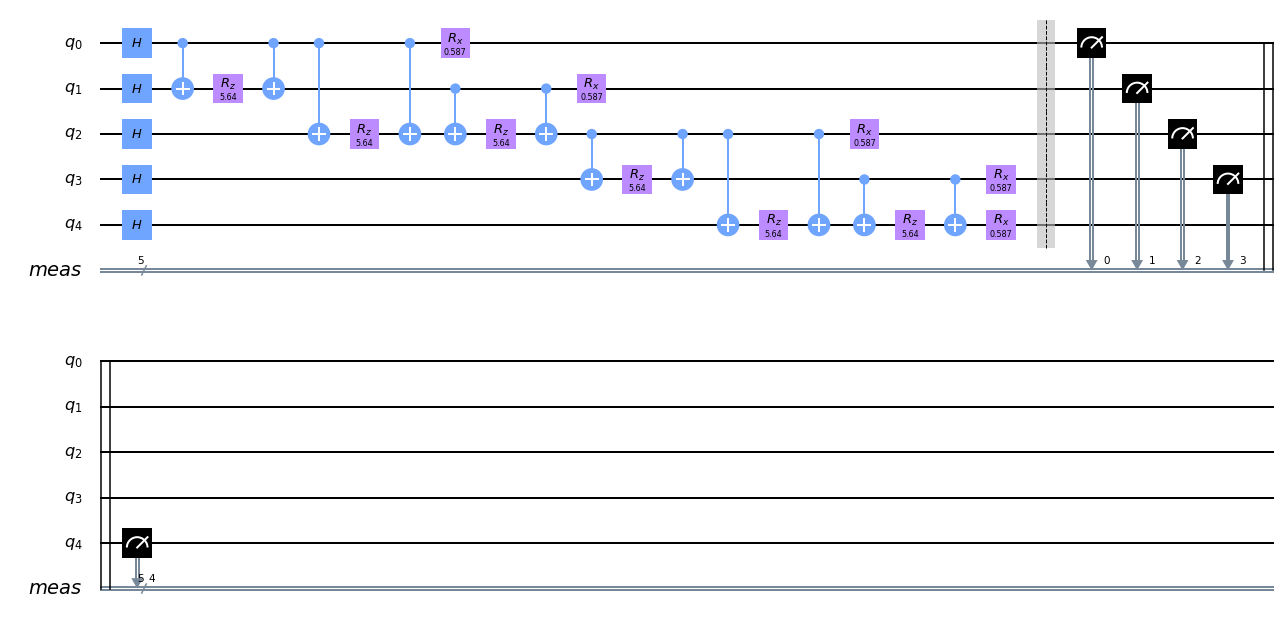

In [28]:
params = model.trainable_variables

print(params)

phase_h.perEdgeMap([params[0].numpy()[0]],1, G, False, False)
mx_ham.generalXMixer([params[0].numpy()[1]],1, phase_hMap, True)

# Add the hadamard circuit back and cost and mixer hamltonians
cir_opt = cir_h + phase_h / mx_ham
cir_opt.draw(output='mpl')

In [29]:
# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import execute
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

res_graph = ex_vle(obj_function,variables,is_graph=True)

# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 1024

simulate     = execute(cir_opt, backend=backend, shots=shots)
results = simulate.result()
mx_c = res_graph.get_expectationValue(results,shots,G)
print('Expectation value:', mx_c)
print('Approximation Ratio:',mx_c/ np.max(cut_size))

Expectation value: 3.923828125
Approximation Ratio: 0.98095703125


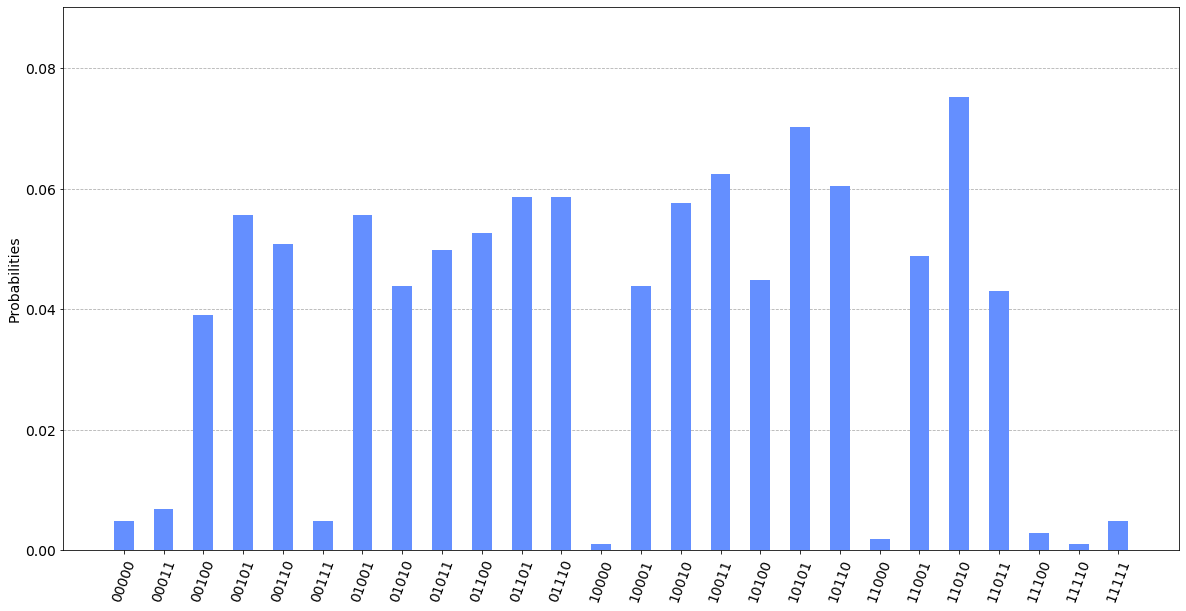

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram(results.get_counts(),figsize = (20,10),bar_labels = False)

## Using a classical optimizer
***
Just for comparision we will use SciPy Optimizers to see how it fares aganist the tfq ML optimization, using 'Predefined_Example's' MAX_CUT problem.

If we compare to the **scipy** optimizer for this particular graph, it would seem that both are fairly good at optimizing the hyperparameters.Using the Predefined Examples we can get a expectation value of the circuit using the classical optimizer, however, in this case one should take note: The **starting hyperparameters** will affect the results of the program which is unlike tfq which does not require a good starting point:

In [31]:
# import the predefined library
import os 
os.path.abspath(os.curdir)
os.path.sys.path.append('../predefined_problems/')

import max_cut as mc

# instantiate a MAX_CUT object which prepares converts the objective function into a pauli hamiltonian
max_cut = mc.max_cut(1,G)

from scipy import optimize as opt
kwargs = {'x0':[0.0, 0.0],
            'method': 'COBYLA'}
opt_hyperparams = max_cut.run_QAOA(opt.minimize, **kwargs)

max_cut.generate_quantumCircuit(G, opt_hyperparams)
res = max_cut.run_circuit()

print('approximation ratio:',res_graph.get_expectationValue(res,shots,G)/np.max(cut_size) )

backend setup: Complete running circuit
Simulation: Complete!
Expectation Value : 3.908203125
approximation ratio: 0.97705078125


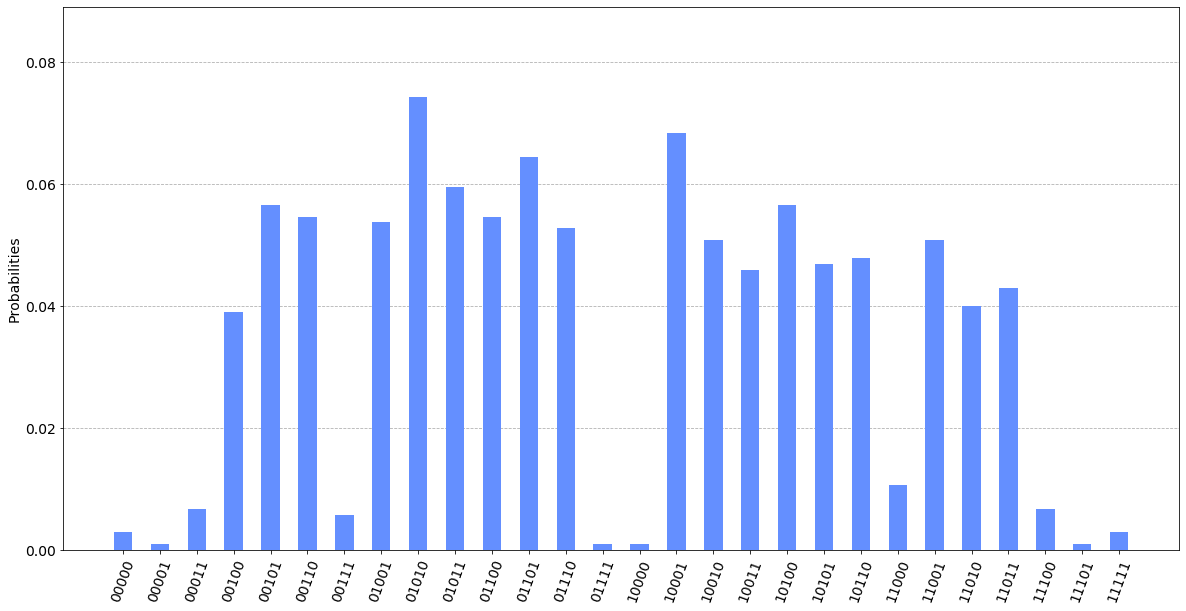

In [32]:
from qiskit.visualization import plot_histogram
plot_histogram(res.get_counts(),figsize = (20,10),bar_labels = False)

Each optimizer's performance may vary on a case-by-case basis, however, the current **tfq_helper** class can only support up to **P=1** steps, unlike **SciPy** Optimizer which can support for **P>1**. In later versions of the toolkit will add a support for users who wish to use higher number of p-steps for the circuits